In [1]:
import numpy as np
from tqdm import tqdm, trange
from scipy.sparse import coo_matrix, hstack,vstack
from scipy.interpolate import griddata
from scipy.optimize import fsolve
from scipy import integrate
import sympy as sp

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from collections import Counter

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "times",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/bel fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}

plt.rcParams.update(tex_fonts)

def solveBetaFunction(x, gamma, amp):
    beta = np.zeros(len(x))
    for idx, val in enumerate(x):
        beta[idx] = amp*np.cos(gamma*np.arccos(val))
    return beta

def tauFunc(x, gamma, amp):
    return amp * np.exp(-gamma * x) 
    #return 0.5 * np.cos(0.8 * x)

def gFunc(x, gamma, amp):
    return x - tauFunc(x, gamma, amp)

def inverse_function(y, gamma, amp):
    result = fsolve(lambda x: gFunc(x, gamma, amp) - y, np.zeros(len(y)))
    return result

def cFunc(x):
    return 20 - 20 * x

def numerical_derivative(f, x, gamma, amp, h=1e-5):
    df = (f(x + h, gamma, amp) - f(x - h, gamma, amp)) / (2 * h)
    return df

def fFunc(x, y):
    return 5 * np.cos(2 * np.pi * x) + 5 * np.sin(2 * np.pi * y) 

def buildF(x):
    s_cood, q_cood = np.meshgrid(x, x, indexing="ij")
    return fFunc(s_cood, q_cood)

def get_cof_equ_K_19(i, N1, f1_m, hx, a):
    num = N1 - i - 2
    coff = f1_m[i, i+1:N1-1].T
    cofi1 = coo_matrix((2 * np.ones(num), (range(num), range(num))), shape = (num, num)).tocsr()
    cofi1 = cofi1 + coo_matrix((-1 * np.ones((num - 1)), (range(num - 1),range(1, num))),shape = (num, num)).tocsr()
    cofi3_1 = np.tril(np.ones((num, num))) - np.diag(1 / 2 * np.ones(num))
    cofi3_1 = hx * cofi3_1
    cofi3_2 = np.zeros((num,num))
    for k in range(num):
        cofi3_2[k, 0:k] = f1_m[i + 1: i + k + 1, i + k + 1].T
    cofi3 = -hx / (a) * cofi3_1 * cofi3_2
    cofi = cofi1 + coo_matrix(cofi3).tocsr() 
    return cofi, coff


def KernelCalc2(a , hx, f1_m): 
    fii = np.diag(f1_m)
    cofmed = np.zeros((N1, N1))
    cofmed[:, -1] = 1/ 2 * np.ones((1, N1))
    cof_int_zeta_1 = hx * (np.triu(np.ones((N1, N1))) - cofmed - np.diag(1 / 2 * np.ones(N1)))
    K_ii = -1 / a * np.dot(cof_int_zeta_1, fii)
    K = np.diag(K_ii)

    for i in range(N1 - 3, -1, -1 ):
        [cofi, coff] = get_cof_equ_K_19(i,N1,f1_m,hx,a)
        Kibud = K[i, i] * hx * hx / (2 * a) - hx / a
        Ki = np.linalg.solve(cofi.toarray(), K[i+1,i+1:N1-1].T) + np.linalg.solve(cofi.toarray(), np.dot(Kibud, coff))
        K[i, i+1:N1-1]=Ki.T  
    Kbud = K[0, :]
    return K, Kbud 

def iteration_k(iterationNum, gBar, gamma, amp):
    s, q = np.meshgrid(spatial, spatial, indexing="ij")
    k_0 = np.zeros((N1, N1))

    for i in range(N1):
        for j in range(i, N1):
            ff = lambda theta: 5 * np.cos(2 * np.pi * (theta + s[i, j] - q[i, j])) + 5 * np.sin(2 * np.pi * theta) 
            k_0[i, j]= -1 * integrate.quad(ff, q[i, j], 1)[0] - cFunc(s[i, j] - q[i, j] + 1) 
  
    simpsonIntCoe = np.ones((N1, N1))
    simpsonIntCoe[0, :] = 0.5
    simpsonIntCoe[-1, :] = 0.5
    simpsonIntCoe[:, 0] = 0.5
    simpsonIntCoe[:, -1] = 0.5
    
    
    kSum = k_0
    K_iteration = k_0
    for _ in range(iterationNum):
        K_iteration_temp = np.zeros((N1, N1))
        for ii in range(N1):#s
            for jj in range(ii, N1):#q
                mSequence = np.linspace(0, 1 - q[ii, jj], N1)
                dm = abs(mSequence[2] - mSequence[1])
                rSequence = np.linspace(s[ii, jj], q[ii, jj], N1)
                dr = abs(rSequence[2]-rSequence[1])
                
                mMatrix, rMatrix = np.meshgrid(mSequence, rSequence, indexing="ij")
                f_obj = fFunc(mMatrix + rMatrix, mMatrix + q[ii, jj]) 
                
                x_qCoodinate = np.hstack((s.flatten()[:,None], q.flatten()[:,None]))
                k_obj = griddata(x_qCoodinate, K_iteration.ravel(), (mMatrix + s[ii, jj], mMatrix + rMatrix), method="linear", fill_value = 0)

                rrSequence = np.linspace(s[ii, jj] - q[ii, jj] + 1, 1, N1)
                drr = abs(rrSequence[2] - rrSequence[1])
                k2_obj = griddata(x_qCoodinate, K_iteration.ravel(), (s[ii, jj] - q[ii, jj] + 1, rrSequence), method="linear", fill_value = 0)
                K_iteration_temp[ii, jj] = np.sum(dm * dr * f_obj * k_obj * simpsonIntCoe) + np.trapz( k2_obj.squeeze() * cFunc(rrSequence).squeeze(), dx = drr)

        K_iteration = K_iteration_temp      
        kSum =  kSum + K_iteration_temp
    print("aa")
    return kSum, kSum[0, :]


def get_cof_1(ht,hx,N,a,f_m1,c,tau):
    N1=N+1
    cof_int_zeta_1_Nplus1 = get_cof_int_zeta_1(N1,hx)
    cof_int_zeta_1 = cof_int_zeta_1_Nplus1 
    cof_int_zeta_1[0, :] = 0
    C1 = a * ht / hx
    Nsquare = (N1) * N
    At1 = coo_matrix(((1-C1) * np.ones(N), (range(1, N1), range(1, N1))),shape = (N1, N1)).tocsr()
    At1 = At1 + coo_matrix((C1 * np.ones(N), (range(1, N1), range(N1-1))),shape = (N1, N1)).tocsr()
    At1 = At1 + ht * coo_matrix(cof_int_zeta_1 * f_m1).tocsr()

    At2 = coo_matrix((N1,Nsquare)).tocsr()
    At2 = At2 + coo_matrix((c[1 : N+1] * ht, (range(1, N1), range(N, N * (N + 1), N))), shape = (N1, Nsquare)).tocsr()
    tauuu = (np.array(tau) * np.ones((N,N+1))).reshape((-1, 1), order = "f")

    ee = ht / (hx * tauuu)
    diag_vale_c = (1 - ee).squeeze()
    diag_vale_l = ee.squeeze()
    diag_vale_l[N - 1 : Nsquare : N] = 0
    diag_vale_l = np.delete(diag_vale_l, -1)

    At4 = coo_matrix((diag_vale_c, (range(Nsquare), range(Nsquare))), shape = (Nsquare,Nsquare)).tocsr()
    At4 = At4 + coo_matrix((diag_vale_l, (range(Nsquare - 1), range(1, Nsquare))),shape = (Nsquare, Nsquare)).tocsr()

    eee = ee[0 : Nsquare : N].squeeze()

    At3 = coo_matrix((eee, (range(N - 1, Nsquare, N), N1 * [N])), shape = (Nsquare, N1)).tocsr()
    Aa1 = vstack((At1, At3))
    Aa2 = vstack((At2, At4))

    return hstack((Aa1, Aa2))


def coefficient_matrix(length):#contrl3的积分系数
    obj_matrix = np.triu(np.ones((length, length))) - np.diag(0.5 * np.ones(length))
    obj_matrix[0, :] = 1 / 2
    obj_matrix[:, -1] = 1 / 2
    return obj_matrix * dx * dx


def solve_contrl_U_large_delay(uu, tau, Kbud, xu, coe_m):
    u1_temp_y = spatial / (a * tau)
    u1_x, u1_y = np.meshgrid(spatial, u1_temp_y)

    u2_temp_y = spatial / (a * tau)
    u2_x, u2_y = np.meshgrid(spatial, u2_temp_y)
    
    x_star = np.hstack((zeta1_m.flatten()[:,None], eta1_m.flatten()[:,None]))


    u1 = np.diag(griddata(x_star, uu.ravel(), (u1_x, u1_y), method="cubic", fill_value = 0))
    u2 = griddata(x_star, uu.ravel(), (u2_x, u2_y), method="cubic", fill_value = 0)  

    contrl1 = np.trapz( Kbud * xu, dx = dx)
    # contrl2 = np.trapz(c1 * u1 / a, dx = dx)
    # #处理c
    # c_m = np.tile(c1, (nx, 1))
    # contrl3 = np.sum(c_m * K * u2 * coe_m)
    # U = contrl1 - contrl2 + contrl3
    U = contrl1
    return U

def solve_contrl_U_little_delay(uu, K,  Kbud, xu, gamma, amp):

    x_star = np.hstack((zeta1_m.flatten()[:,None], eta1_m.flatten()[:,None]))
    
    #control1
    contrl1 = np.trapz(Kbud * xu, dx = dx)
    
    # #control2
    # sequence2 = np.linspace(0, g_inverse_0, N1)#0\rightarrow g^{-1}(0)
    # dx2 = abs(sequence2[1]-sequence2[2])
    # u2_temp_y = sequence2 / (tauFunc(sequence2, gamma, amp))
    # u2_x, u2_y = np.meshgrid(sequence2, u2_temp_y, indexing="ij")
    # u2 = np.diag(griddata(x_star, uu.ravel(), (u2_x, u2_y), method="cubic", fill_value = 0))
    # contrl2 = np.trapz(cFunc(sequence2) * u2 , dx = dx2)
    

    
    # sequence3_1 = np.linspace(g_inverse_0, 1, N1)#g^{-1}(0)\rightarrow 1
    # dx3_0 = abs(sequence3_1[1] - sequence3_1[2])
    # intAtP = np.zeros(N1)
    # for qKey, qValue in enumerate(sequence3_1):
    #     sequence3_2 = np.linspace(0, tauFunc(qValue, gamma, amp), N1)#p轴网格点的值
    #     dx3_1 = abs(sequence3_2[1] - sequence3_2[2])
    #     #q视作常数 ， p在变化
    #     K_control3 = griddata(x_star, K.ravel(), (sequence3_2, qValue *np.ones(N1)), method="cubic", fill_value = 0)
    #     u3 = griddata(x_star, uu.ravel(), (qValue * np.ones(N1), sequence3_2 / tauFunc(qValue, gamma, amp)), method="cubic", fill_value = 0)  
    #     intAtP[qKey] = np.trapz(K_control3 * u3, dx = dx3_1) 
    # contrl3 = np.trapz(intAtP, dx = dx3_0) 
    
    # #control4
    # sequence4 = sequence2
    # dx4 = dx2
    # coe4 = np.tril(np.ones((N1, N1))) - np.diag(0.5 * np.ones(N1)) 
    # coe4[0, :] = 0.5
    # coe4[:, -1] = 0.5
    # coem4 = coe4 * dx4 * dx4
    
    # u4_x, u4_y_0 = np.meshgrid(sequence4, sequence4, indexing="ij") 
    # u4_y = u4_x / tauFunc(u4_x, gamma, amp)#\frac{p}{\tau (q)}
    # #对u,k插值
    # u4 = griddata(x_star, uu.ravel(), (u4_x, u4_y), method="cubic", fill_value = 0)  
    # K_control4 = griddata(x_star, K.ravel(), (u4_x, u4_y_0), method="cubic", fill_value = 0)
    # c_m4 = np.tile(cFunc(sequence4), (N1, 1))
    # contrl4 = np.sum(c_m4 * K_control4 * u4 * coem4)

    U = contrl1 #- contrl2 + contrl3 + contrl4
    return U


def get_cof_int_zeta_1(N,hx):
    cofmed = np.zeros((N,N))
    cofmed[:, N - 1] = 1 / 2 * np.ones((1,N))
    cof_int_zeta_1 = hx * (np.triu(np.ones((N,N))) - cofmed - np.diag(1 / 2 * np.ones(N)))
    return cof_int_zeta_1

In [2]:
a = 1
X = 1
dx = 1 / 20
nx = int(round(X/dx))+1
spatial = np.linspace(0, X, nx, dtype=np.float32)
N1 = len(spatial)
N = N1 - 1
#para of delay###################################################
gamma = 1.6
amp = 0.8

print("gamma:", gamma, "amp", amp)


c1 = cFunc(spatial)
[eta1_m, zeta1_m]= np.meshgrid(spatial,spatial)

f1_m = buildF(spatial)
fii = np.diag(f1_m)


final_time = 1
ht = 0.0025
Maxstep = int(final_time / ht)
time = np.linspace(0, final_time, Maxstep + 1) 

tauTrue = tauFunc(spatial, gamma, amp)


UCalc = np.zeros(Maxstep)

coe_m = coefficient_matrix(nx)

A = get_cof_1(ht, dx, N, a, f1_m, c1, tauTrue)# 
x_u2 = np.zeros((N1 ** 2, Maxstep + 1))

xx2 = 4 * np.cos(3 * np.arccos(spatial - 0.3))

uu2 = np.zeros((N * N1, 1)).squeeze()
x_u2[:, 0] = np.hstack((xx2, uu2))
xx_uu2 = x_u2[:, 0]

K, Kbud = iteration_k(10, gFunc(1, gamma, amp), gamma, amp)




for tt in trange(Maxstep):
    uu_temps2 = np.around(xx_uu2[N1 : ].reshape((N, N1), order = "f"), 5).T
    uu_temps2 = np.hstack((uu_temps2, xx_uu2[N1 - 1] * np.ones((N+1,1)))) 

    UCalc[tt] = solve_contrl_U_little_delay(uu_temps2, K, Kbud, xx_uu2[: N1], gamma, amp)
    xx_uu2 = A @ x_u2[:, tt]#迭代   
    xx_uu2[0] = UCalc[tt]
    x_u2[:, tt+1] = xx_uu2
X2 = x_u2[0 : N1, :]



gamma: 1.6 amp 0.8
aa


100%|██████████| 400/400 [00:00<00:00, 21578.69it/s]


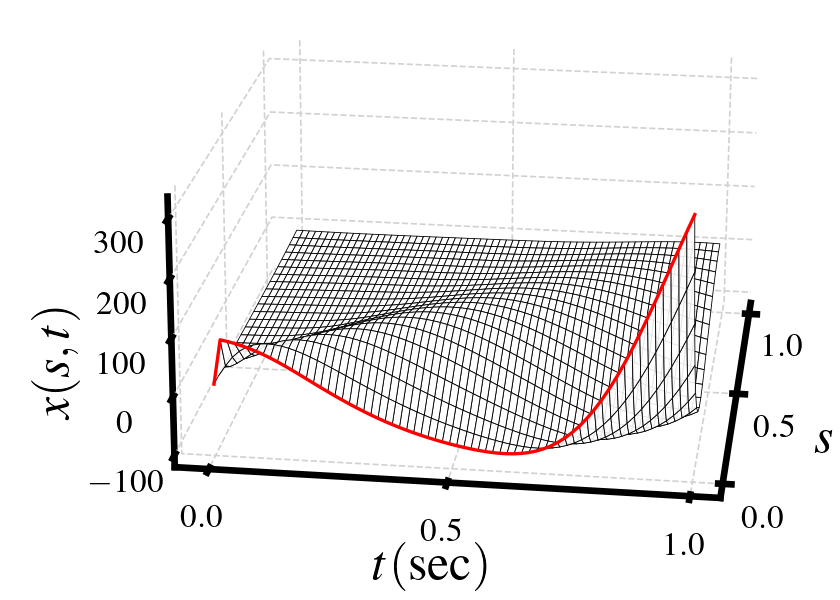

In [3]:
############### draw output
draw_rate = 6
my_dpi = 600
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}
nt_draw = Maxstep + 1
temporal_draw = time[0:nt_draw:draw_rate]
meshx2, mesht2 = np.meshgrid(spatial, temporal_draw, indexing="ij")
test = np.zeros(len(temporal_draw))
fig = plt.figure(figsize=(1.4, 1), dpi=my_dpi)
subfig = fig.subfigures(nrows=1, ncols=1, hspace=0)

ax = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})
for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    axis._axinfo['axisline']['linewidth'] = 0.3
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))

ax.plot_surface(meshx2, mesht2, X2[0:nx, 0:nt_draw:draw_rate], edgecolor="black", lw=0.1,
                color="white", shade=False, rasterized=True, alpha=0.9, antialiased=True, rstride=1, cstride=1)

ax.plot(test, temporal_draw, X2[0, 0:nt_draw:draw_rate], color="red", lw=0.4, antialiased=True)
ax.invert_xaxis()
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 1, 0.7, 0.8])) 
ax.view_init(20, 8)
ax.set_xlabel(r"$s$", fontsize=6, labelpad=-14)
ax.set_ylabel(r"$t(\mathrm{sec})$", fontsize=6, labelpad=-14)
ax.yaxis.set_rotate_label(False)
ax.set_zlabel(r"$x(s,t)$", fontsize=6, rotation=90, labelpad=-14)
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0, 0.5, 1])

ax.zaxis.set_rotate_label(False)
ax.tick_params(axis='both', labelsize=4, pad=-5)  
plt.subplots_adjust(top=1.1, bottom=0.01, right=1, left=0, hspace=0, wspace=0)
plt.savefig('../picture2/1108/NoCompensation_little.png', dpi=my_dpi)


In [4]:
final_time = 8
ht = 0.025
gammaTau = 5.2
tauTrue = 3 + 0.5 * np.cos( gammaTau * np.arccos(spatial)) 
Maxstep_large = int(final_time / ht)
timeSequence_large = np.linspace(0, final_time, Maxstep_large + 1) 

UCalc_large = np.zeros(Maxstep_large)
lossU_large = np.zeros(Maxstep_large, dtype=np.float32)

coe_m = coefficient_matrix(nx)
A = get_cof_1(ht, dx, N, a, f1_m, cFunc(spatial), tauTrue)

x_u2_large = np.zeros((N1 ** 2, Maxstep_large + 1))
xx2_large = xx2 
uu2_large = np.zeros((N * N1, 1)).squeeze()
x_u2_large[:, 0] = np.hstack((xx2_large, uu2_large))
xx_uu2_large = x_u2_large[:, 0]
UCalc_large = np.zeros(Maxstep_large)


K, Kbud =  KernelCalc2(1, dx, f1_m)

for tt in trange(Maxstep_large):
    uu_temps2 = np.around(xx_uu2_large[N1 : ].reshape((N, N1), order = "f"), 5).T
    uu_temps2 = np.hstack((uu_temps2, xx_uu2_large[N1 - 1] * np.ones((N+1,1))))   

    UCalc_large[tt] = solve_contrl_U_large_delay(uu_temps2, tauTrue, Kbud, xx_uu2_large[: N1], coe_m)
            
    xx_uu2_large = A @ x_u2_large[:, tt]#迭代   
    xx_uu2_large[0] = UCalc_large[tt]
    x_u2_large[:, tt+1] = xx_uu2_large
    
X2_large = x_u2_large[0 : N1, :]



  0%|          | 0/320 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:01<00:00, 194.08it/s]


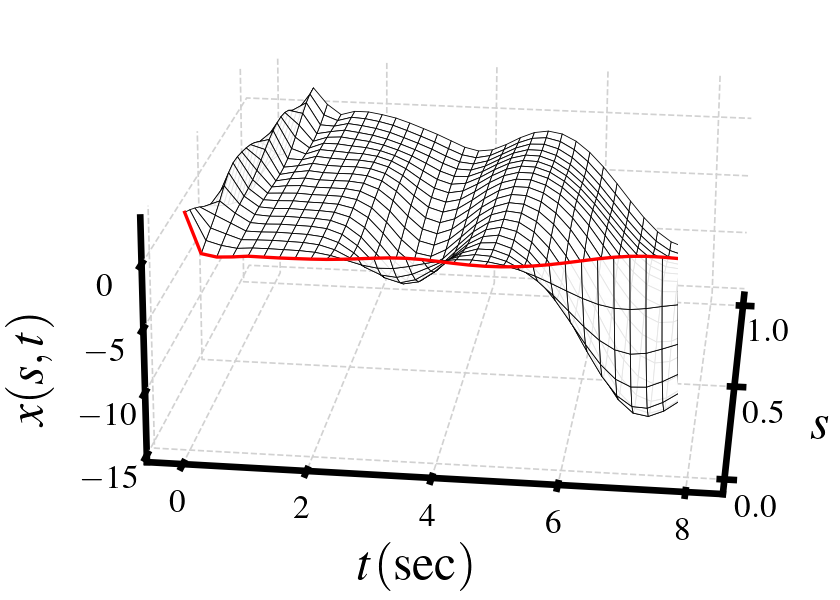

In [5]:

############### draw output
draw_rate_large = 10
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

nt_draw_large = Maxstep_large + 1
temporal_draw_large=timeSequence_large[0:nt_draw_large:draw_rate_large]
meshx2_large, mesht2_large = np.meshgrid(spatial, temporal_draw_large, indexing="ij")
test_large=np.zeros(len(temporal_draw_large))
fig = plt.figure(figsize=(1.4, 1), dpi=my_dpi)
subfig = fig.subfigures(nrows=1, ncols=1, hspace=0)

ax = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})
for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))

ax.plot_surface(meshx2_large, mesht2_large, X2_large[0:nx, 0:nt_draw_large:draw_rate_large], edgecolor="black", lw=0.1, 
                color="white", shade=False, rasterized=True, alpha=0.9, antialiased=True, rstride=1, cstride=1, )
ax.plot(test_large, temporal_draw_large, X2_large[0, 0:nt_draw_large:draw_rate_large], color="red", lw=0.4, antialiased=True)
ax.invert_xaxis()
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 1, 0.6, 0.7])) 
ax.view_init(20, 8)
ax.set_xlabel(r"$s$", fontsize=6, labelpad=-15)
ax.set_ylabel(r"$t(\mathrm{sec})$", fontsize=6, labelpad=-14)
ax.yaxis.set_rotate_label(False)
ax.set_zlabel(r"$x(s,t)$", fontsize=6, rotation=90, labelpad=-15)
ax.set_xticks([0, 0.5, 1])
# ax.set_yticks(y_axis_ticks)
ax.set_zticks([-15, -10, -5, 0])

ax.zaxis.set_rotate_label(False)
ax.tick_params(axis='both', labelsize=4, pad=-6) 
plt.subplots_adjust(top=1, bottom=0, right=0.9, left=0, hspace=0, wspace=0)
plt.savefig('../picture2/1108/NoCompensation_large.png', dpi=my_dpi)

